We now extend SEIR model to:

\begin{align}
\dot{S_{i}}	&=-\lambda_{i}(t)S_{i}+\sigma_{i}, \\
\dot{E}_{i}	&=\lambda_{i}(t)S_{i}-\gamma_{E}E_{i},\\
\dot{I}_{i}^{a}	&=\alpha\gamma_{E}E_{i}-\gamma_{I^{a}}I_{i}^{a},\\
\dot{I}_{i}^{s}	&=\bar{\alpha}\gamma_{E}E_{i}-\gamma_{I^{s}}I_{i}^{s},\\
\dot{I}_{i}^{h}	&=h_{i}\gamma_{I^{s}}I_{i}^{s}-\gamma_{I^{h}}I_{i}^{h},\\
\dot{I}_{i}^{c}	&=c_{i}\gamma_{I^{h}}I_{i}^{h}-\gamma_{I^{c}}I_{i}^{c},\\
\dot{I}_{i}^{m}	&=m_{i}\gamma_{I^{c}}I_{i}^{c},\\
\dot{R}_{i} &=\gamma_{I^{a}}I_{i}^{a}+\bar{h}_{i}\gamma_{I^{s}}I_{i}^{s}+\bar{c}_{i}\gamma_{I^{h}}I_{i}^{h}+\bar{m}_{i}\gamma_{I^{c}}I_{i}^{c},\\
\dot{N}_{i}	&=\sigma_{i}-I_{i}^{m}.
\end{align}


$\lambda_{i}(t)=\beta\sum_{j=1}^{M}\left(C_{ij}^{a}\frac{I_{j}^{a}}{N_{j}}+C_{ij}^{s}\frac{I_{j}^{s}}{N_{j}}+C_{ij}^{h}\frac{I_{j}^{h}}{N_{j}}\right)$.

Here 
* $I^{a}$ : asymptomatic infectives
* $I^{s}$ : symptomatic infectives
* $I^{h}$ : hospitalized infectives
* $I^{c}$ : ICU cases 
* $I^{m}$ : mortality
* ${h}_{i}=1-\bar h_{i}$ is the fraction of syptomatics who are hospitalized
* $c_{i}=1-\bar{c}_{i}$, is the fraction of hospitalizeds, who are in ICU
* $m_{i}=1-\bar{m}_{i}$, is the fraction of ICU which leads to mortality
* $C_{ij}^{s}=f^{s}C_{ij}^{a}\equiv f^{s}C_{ij}$  
* $C_{ij}^{h}=f^{h}C_{ij}^{a}\equiv f^{h}C_{ij}$. 

S ---> E ---> Ia, Is 

Ia ---> R

Is ---> Ih, R

Ih ---> Ic, R

Ic ---> Im, R

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
M=16  # number of age groups

# load age structure data
my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

# set age groups
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

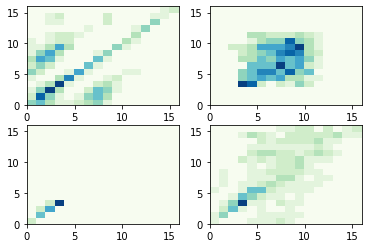

In [4]:
# contact matrices
CH, CW, CS, CO = pyross.contactMatrix.UK()


## matrix of total contacts
C=CH+CW+CS+CO


fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

## Fraction of asymptomatic infectives is constant

In [5]:
beta  = 0.036692            # infection rate 

gE    = 1/5
gIa   = 1./7                # recovery rate of asymptomatic infectives 
gIs   = 1./7                # recovery rate of symptomatic infectives 
alpha = 0.3                 # fraction of asymptomatic infectives 
fsa   = 0.2                 # the self-isolation parameter   
fh    = 0
gIh   = 1/14
gIc   = 1/14
 
sa    = 100*np.ones(M)      #  rate of additional/removal of population by birth etc
sa[0]     = 1500            # birth
sa[12:16] = -300            # mortality


hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC



# initial conditions    
Is_0 = np.zeros((M));  #Is_0[6:13]=8;  Is_0[2:6]=4; Is_0[13:16]=4


Ia_0 = 1000*np.ones((M));  
R_0  = np.zeros((M))
E_0  = np.zeros((M))
Ih_0  = np.zeros((M))
Ic_0  = np.zeros((M))
Im_0  = np.zeros((M))

S_0  = Ni - (Ia_0 + Is_0 + R_0)


# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))

for i in range(M):
    for j in range(M):
        L0[i,j]=C[i,j]*Ni[i]/Ni[j]

L[0:M, 0:M]     =    alpha*beta/gIs*L0
L[0:M, M:2*M]   = fsa*alpha*beta/gIs*L0
L[M:2*M, 0:M]   =    ((1-alpha)*beta/gIs)*L0
L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gIs)*L0


r0 = np.max(np.linalg.eigvals(L))
print("The basic reproductive ratio for these parameters is", r0)

The basic reproductive ratio for these parameters is (1.319908017634234+0j)


16000.0

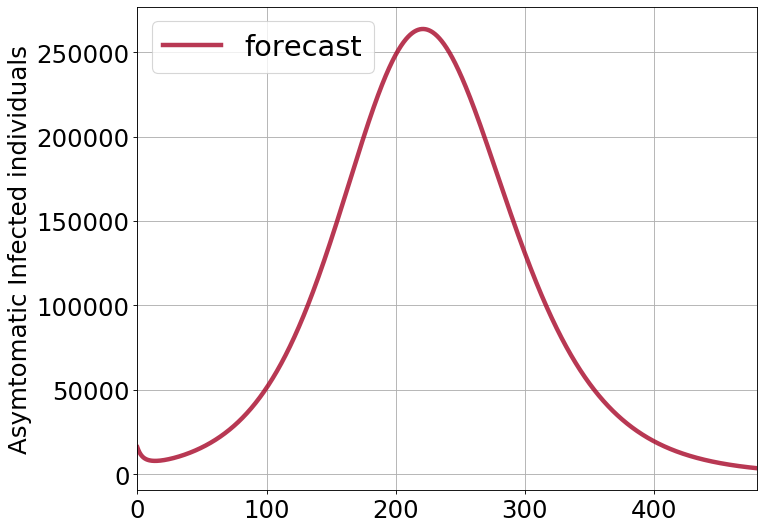

In [6]:
# duration of simulation and data file
Tf=480;  Nf=2000;  



# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.deterministic.SEI5R(parameters, M, Ni)



# the contact structure is independent of time 
def contactMatrix(t):
    return C
# run model
data=model.simulate(S_0, E_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, contactMatrix, Tf, Nf)


t = data['t']; IC  = np.zeros((Nf))
for i in range(1*M):
        IC += data['X'][:,2*M+i]
        

        
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)

 
plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Asymtomatic Infected individuals'); #plt.xlim(0, 40); plt.ylim(0, 4);
#plt.savefig('/Users/rsingh/Desktop/2a.png', format='png', dpi=212)
IC[0]

## Fraction of asymptomatic infectives is age-dependent

In [7]:
alpha = 0.5*np.ones(M)      #  rate of additional/removal of population by birth etc
alpha[6:M] = 0.1              # everyone is symtomatic in large age-group

Ia_0 = 1000*np.ones((M));  

16000.0

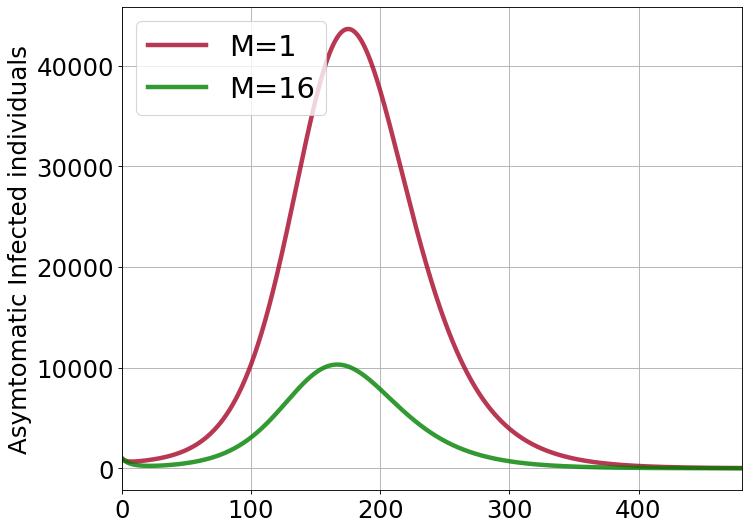

In [9]:


# duration of simulation and data file
Tf=480;  Nf=2000;  



# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.deterministic.SEI5R(parameters, M, Ni)



# the contact structure is independent of time 
def contactMatrix(t):
    return C
# run model
data=model.simulate(S_0, E_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, contactMatrix, Tf, Nf)


t = data['t']; IC1  =  data['X'][:,2*M+1]; 
IC2  =  data['X'][:,2*M+8]


        
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, IC1, '-', lw=4, color='#A60628', label='M=1', alpha=0.8)
plt.plot(t, IC2, '-', lw=4, color='green', label='M=16', alpha=0.8)


 
plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Asymtomatic Infected individuals'); #plt.xlim(0, 40); plt.ylim(0, 4);
#plt.savefig('/Users/rsingh/Desktop/2a.png', format='png', dpi=212)
IC[0]